In [1]:
from google.colab import drive
drive.mount("/content/drive")



Mounted at /content/drive


# **PRE-PROCESSING**

In [23]:
############################################################# PREPROCESSING

import numpy as np 
import pandas as pd 
import nltk
import string

#from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

def remove_stopwords(text) :
  arr_of_words=text.split()
  return_text=''
  for word in arr_of_words :
    if word not in stop :
      return_text+=word
      return_text+=' '
  return return_text

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

def make_lower(text) :
  lower_text=text.lower()
  return lower_text

def remove_numbers(text) :
  alpha_text=''
  arr_of_words=text.split()
  for i in arr_of_words :
    try :
      x=int(i)
    except ValueError :
      alpha_text+=i
      alpha_text+=' '
  return alpha_text

def deal_media(text) :
  arr_of_words=text.split()
  final_text=''
  for i in arr_of_words :
    if 'http://' in i :
      word='aszxdcfvgb'
    else :
      word=i
    final_text+=word
    final_text+=' '
  return final_text

def remove_nan(text) :
  text = text.replace(' nan ', '')
  return text



df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ML_Project/ML_data/train.csv") 
test_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ML_Project/ML_data/test.csv")


#adding location to train text
df["text"] = df["text"] + ' ' + df["location"].astype(str) +' '

df["text"] = df["text"].apply(remove_nan)
df["text"] = df["text"].apply(deal_media)
df["text"] = df["text"].apply(remove_stopwords)
df["text"] = df["text"].apply(remove_punctuations)
df["text"] = df["text"].apply(make_lower)
df["text"] = df["text"].apply(remove_numbers)

#adding location to test text
test_df["text"] = test_df["text"] + ' ' + test_df["location"].astype(str) +' '

test_df["text"] = test_df["text"].apply(remove_nan)
test_df["text"] = test_df["text"].apply(deal_media)
test_df["text"] = test_df["text"].apply(remove_stopwords)
test_df["text"] = test_df["text"].apply(remove_punctuations)
test_df["text"] = test_df["text"].apply(make_lower)
test_df["text"] = test_df["text"].apply(remove_numbers)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# check class distribution
df['target'].value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

# **split dataset**

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
!pip install transformers==3.0.0
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

     |████████████████████████████████| 757kB 8.2MB/s 
     |████████████████████████████████| 901kB 13.3MB/s 
     |████████████████████████████████| 1.2MB 21.6MB/s 
     |████████████████████████████████| 3.0MB 51.6MB/s 


In [25]:

train_text, val_text, train_labels, val_labels = train_test_split(df['text'], df['target'], 
                                                                    random_state=2018, 
                                                                    test_size=0.05, 
                                                                    stratify=df['target'])

test_text = test_df['text']

# **Start of Bert model: importing and tokenising**

In [38]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

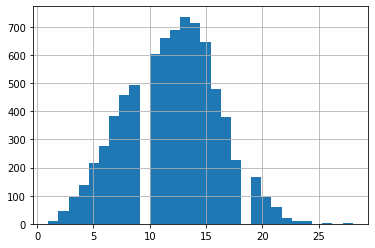

In [39]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [40]:
max_seq_len = 16 #from the diagram

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


# **Converting into Tensors**

In [41]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())


# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

In [42]:
#Creating DataLoaders

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)



In [43]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# **Model Architecture**

In [44]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x


# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# **Class Imbalance**

In [45]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

[0.87666974 1.1637114 ]


# **Train and Evaluate model**

In [46]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [47]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [48]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    238.
  Batch   100  of    238.
  Batch   150  of    238.
  Batch   200  of    238.

Evaluating...

Training Loss: 0.608
Validation Loss: 0.538

 Epoch 2 / 10
  Batch    50  of    238.
  Batch   100  of    238.
  Batch   150  of    238.
  Batch   200  of    238.

Evaluating...

Training Loss: 0.566
Validation Loss: 0.655

 Epoch 3 / 10
  Batch    50  of    238.
  Batch   100  of    238.
  Batch   150  of    238.
  Batch   200  of    238.

Evaluating...

Training Loss: 0.549
Validation Loss: 0.487

 Epoch 4 / 10
  Batch    50  of    238.
  Batch   100  of    238.
  Batch   150  of    238.
  Batch   200  of    238.

Evaluating...

Training Loss: 0.555
Validation Loss: 0.526

 Epoch 5 / 10
  Batch    50  of    238.
  Batch   100  of    238.
  Batch   150  of    238.
  Batch   200  of    238.

Evaluating...

Training Loss: 0.537
Validation Loss: 0.506

 Epoch 6 / 10
  Batch    50  of    238.
  Batch   100  of    238.
  Batch   150  of    238.
  Batch   20

In [49]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# **Metrics on train data**

In [50]:
train_text=df['text']
train_labels=df['target']

max_seq_len = 16
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())


with torch.no_grad():
  preds = model(train_seq.to(device), train_mask.to(device))
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)

print(classification_report(train_labels, preds))

#pd.crosstab(train_labels, preds)

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      4342
           1       0.77      0.66      0.71      3271

    accuracy                           0.77      7613
   macro avg       0.77      0.76      0.76      7613
weighted avg       0.77      0.77      0.77      7613



In [51]:
pd.crosstab(train_labels, preds)


col_0,0,1
target,,
0,3694,648
1,1111,2160


# **Metrics on Test data**

In [52]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

# model's performance
preds = np.argmax(preds, axis = 1)
print(preds)
print(type(preds))
preds=list(preds)
print(preds)
print(type(preds))

[1 1 1 ... 1 1 1]
<class 'numpy.ndarray'>
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 

In [53]:
# for submission on Kaggle
id_arr=list(test_df["id"])
target_arr=preds
df = pd.DataFrame(list(zip(id_arr, target_arr)),columns =['id', 'target'])
df.to_csv('Submission_file_Bert.csv', index=False)
!cp Submission_file_Bert.csv "drive/My Drive/"
#f1 score is 0.75360